In [1]:
# Bermuda 2019 load in processed data and begin mode projection 
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import gsw
import scipy.io as si
from scipy.optimize import fmin
from scipy.signal import savgol_filter
from netCDF4 import Dataset
import pickle
import datetime
import pickle
# functions I've written 
from glider_cross_section import Glider
from mode_decompositions import eta_fit, vertical_modes, PE_Tide_GM, vertical_modes_f
from toolkit import spectrum_fit, nanseg_interp, plot_pro, find_nearest

# matplotlib.rcParams['figure.figsize'] = (14,10)

# --- PHYSICAL PARAMETERS
g = 9.81
rho0 = 1025  # - 1027
ref_lat = 31.0
ref_lon = 69.5
f_ref = np.pi * np.sin(np.deg2rad(ref_lat)) / (12 * 1800)
# --- MODE PARAMETERS
# frequency zeroed for geostrophic modes
omega = 0
# highest baroclinic mode to be calculated
mmax = 45
nmodes = mmax + 1
# maximum allowed deep shear [m/s/km]
deep_shr_max = 0.1
# minimum depth for which shear is limited [m]
deep_shr_max_dep = 3500
eta_fit_depth_min = 250
eta_fit_depth_max = 3750  # 3900

In [2]:
# --- LOAD in initial processing results
# these include, raw profiles, velocity profiles, displacement profiles, background density profiles...
pkl_file = open('/Users/jake/Documents/baroclinic_modes/DG/sg045_2019_initial_processing.pkl', 'rb')
IP = pickle.load(pkl_file)
pkl_file.close()
ref_lon = IP['ref_lon']
ref_lat = IP['ref_lat']
grid = IP['depth']
grid_p = gsw.p_from_z(-1 * grid, ref_lat)
grid_p[0] = 0
profile_tags = IP['raw_profile_tags']
sa = IP['sa']
ct = IP['ct']
gamma = IP['gamma']
prof_lon = IP['prof_lon']
prof_lat = IP['prof_lat']
prof_time = IP['profile_time']
# bckgrds = IP['background_indices']
# bckgrds_key = IP['background key']
# bd1 = IP['bd1']
# bd2 = IP['bd2']
lon_lim = IP['lon_lim']
lat_lim = IP['lat_lim']

N2 = IP['N2_by_season_quad']
sa_avg = IP['bckgrd_sa']
ct_avg = IP['bckgrd_ct']
theta_avg = IP['bckgrd_theta']
gamma_avg = IP['bckgrd_gamma']
mw_time = IP['mw_time']
mw_lon = IP['mw_lon']
mw_lat = IP['mw_lat']
mw_ct = IP['mw_ct']
mw_sa = IP['mw_sa']
mw_gamma = IP['mw_gamma']
mw_eta_1 = IP['eta_1']
mw_eta_2 = IP['eta_2']
mw_eta_3 = IP['eta_3']
eta_ind_1 = IP['eta_per_1']
eta_ind_3 = IP['eta_per_3']

mw_time_good = IP['mw_time_good']
gamma_good = IP['mw_gamma_good']
mw_eta_1_good = IP['eta_1_good']
mw_eta_2_good = IP['eta_2_good']
mw_eta_3_good = IP['eta_3_good']
box_side_info = IP['box_side_no']
mw_v_good = IP['dg_v_good']
mw_v_e_good = IP['dg_v_e_good']
mw_v_n_good = IP['dg_v_n_good']
mw_prof_good = IP['mw_prof_good']
PE_per_prof = IP['PE_per_prof']
PE_per_prof_time = IP['PE_per_prof_time']
PE_per_prof_tag = IP['PE_per_prof_tag']

u = IP['u_profiles']
u_no = IP['u_prof_no']
dace_u = IP['dac_e_u_profiles']
dacn_u = IP['dac_n_u_profiles']
v = IP['v_profiles']
v_no = IP['v_prof_no']
dace_v = IP['dac_e_v_profiles']
dacn_v = IP['dac_n_v_profiles']

t_s = datetime.date.fromordinal(np.int(np.nanmin(prof_time)))
t_e = datetime.date.fromordinal(np.int(np.nanmax(prof_time)))

In [4]:
print(np.shape(u))
print(np.shape(v))

(450, 15)
(450, 16)


array([  50,  250,  500, 1000, 1500, 2000, 2500, 3000, 3500, 4480], dtype=uint16)

In [44]:
# --- EOFs of glider and model velocity profiles
# glider u 
check1 = 7      # upper index to include in eof computation
check2 = -14     # lower index to include in eof computation
grid_sub_i = [10, 50, 100, 150, 200, 250, 300, 350, 400, 449]
grid_check = grid[grid_sub_i]
not_shallow = np.isfinite(u[-30, :])
not_shallow = np.isfinite(v[-30, :])

# not_shallow = np.isfinite(u[-30, :])
# grid_check = grid[check1:check2]
Uzq = u[grid_sub_i, :].copy()
nq = np.size(Uzq[0, :])
avg_Uzq = np.nanmean(np.transpose(Uzq), axis=0)
Uzqa = Uzq - np.transpose(np.tile(avg_Uzq, [nq, 1]))
cov_Uzqa = (1 / nq) * np.matrix(Uzqa) * np.matrix(np.transpose(Uzqa))
D_Uzqa, V_Uzqa = np.linalg.eig(cov_Uzqa)
t1 = np.real(D_Uzqa[0:10])
PEV = t1 / np.sum(t1)
eof1 = np.real(D_Uzqa[0])*np.array(np.real(V_Uzqa[:, 0]))
eof2 = np.real(D_Uzqa[1])*np.array(np.real(V_Uzqa[:, 1]))
eof3 = np.real(D_Uzqa[2])*np.array(np.real(V_Uzqa[:, 2]))
# glider v
Uzq = v[grid_sub_i, :].copy()
nq = np.size(Uzq[0, :])
avg_Uzq = np.nanmean(np.transpose(Uzq), axis=0)
Uzqa = Uzq - np.transpose(np.tile(avg_Uzq, [nq, 1]))
cov_Uzqa = (1 / nq) * np.matrix(Uzqa) * np.matrix(np.transpose(Uzqa))
Dv_Uzqa, Vv_Uzqa = np.linalg.eig(cov_Uzqa)
t1 = np.real(Dv_Uzqa[0:10])
PEVv = t1 / np.sum(t1)
eof1v = np.real(Dv_Uzqa[0])*np.array(np.real(Vv_Uzqa[:, 0]))
eof2v = np.real(Dv_Uzqa[1])*np.array(np.real(Vv_Uzqa[:, 1]))
# --- glider all velocities
grid_sub_i_2 = [10, 30, 50, 75, 100, 125, 150, 175, 200, 225, 
                250, 275, 300, 325, 350, 375, 400, 425, 449]
Uzq = np.concatenate((u[grid_sub_i_2, :], v[grid_sub_i_2, :]), axis=1)
nq = np.size(Uzq[0, :])
avg_Uzq = np.nanmean(np.transpose(Uzq), axis=0)
Uzqa = Uzq - np.transpose(np.tile(avg_Uzq, [nq, 1]))
cov_Uzqa_all = (1 / nq) * np.matrix(Uzqa) * np.matrix(np.transpose(Uzqa))
D_Uzqa_all, V_Uzqa_all = np.linalg.eig(cov_Uzqa_all)
t1_all = np.real(D_Uzqa_all[0:10])
PEV_all = t1_all / np.sum(t1_all)
eof1_all = np.real(D_Uzqa_all[0])*np.squeeze(np.array(np.real(V_Uzqa_all[:, 0])))
eof2_all = np.real(D_Uzqa_all[1])*np.squeeze(np.array(np.real(V_Uzqa_all[:, 1])))

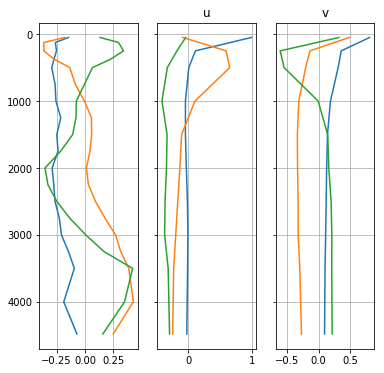

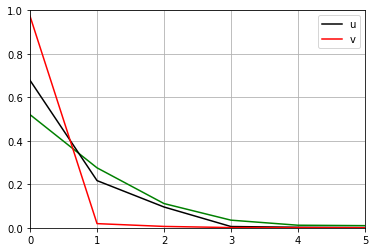

()

In [66]:
# svd 
# --- glider eta    
grid_sub_i_eta = [10, 25, 50, 75, 100, 125, 150, 175, 200, 225, 
              250, 275, 300, 325, 350, 375, 400, 425, 449]
grid_check_eta = grid[grid_sub_i_eta]
etazq = eta_ind_3[grid_sub_i_eta, :].copy()
nq = np.size(etazq[0, :])
avg_etazq = np.nanmean(np.transpose(etazq), axis=0)
data_eta = etazq - np.transpose(np.tile(avg_etazq, [nq, 1]))
[UUe, SSe, VVe] = np.linalg.svd(data_eta, full_matrices=False, compute_uv=True)

p = np.min([np.shape(data_eta)[0], np.shape(data_eta)[1]])
Spe=SSe[0:p];
lambe=np.matrix(Spe[:, None])*np.transpose(np.matrix(Spe[:, None]));
var_eta=np.trace(lambe);
frac_eof_eta=np.diag(lambe)/var_eta;

# --- glider u           
Uzq = u[grid_sub_i, :].copy()
nq = np.size(Uzq[0, :])
avg_Uzq = np.nanmean(np.transpose(Uzq), axis=0)
data = Uzq - np.transpose(np.tile(avg_Uzq, [nq, 1]))
[UU, SS, VV] = np.linalg.svd(data, full_matrices=False, compute_uv=True)

p = np.min([np.shape(data)[0], np.shape(data)[1]])
Sp=SS[0:p];
lamb=np.matrix(Sp[:, None])*np.transpose(np.matrix(Sp[:, None]));
var_u=np.trace(lamb);
frac_eof=np.diag(lamb)/var_u;

# --- glider v           
Vzq = v[grid_sub_i, :].copy()
nq_v = np.size(Vzq[0, :])
avg_Vzq = np.nanmean(np.transpose(Vzq), axis=0)
data_V = Vzq - np.transpose(np.tile(avg_Vzq, [nq_v, 1]))
[UU2, SS2, VV2] = np.linalg.svd(data_V, full_matrices=False, compute_uv=True)

p2 = np.min([np.shape(data_V)[0], np.shape(data_V)[1]])
Sp2=SS2[0:p2];
lamb2=np.matrix(Sp2[:, None])*np.transpose(np.matrix(Sp2[:, None]));
var_v=np.trace(lamb2);
frac_eof_v=np.diag(lamb2)/var_v;

matplotlib.rcParams['figure.figsize'] = (6, 6)
f, (ax0, ax1, ax2) = plt.subplots(1, 3, sharey=True)
ax0.plot(UUe[:, 0], grid_check_eta)
ax0.plot(UUe[:, 1], grid_check_eta)
ax0.plot(UUe[:, 2], grid_check_eta)
ax0.grid()
ax0.invert_yaxis()
ax1.plot(UU[:, 0], grid_check)
ax1.plot(UU[:, 1], grid_check)
ax1.plot(UU[:, 2], grid_check)
ax1.grid()
ax1.set_title('u')
ax2.plot(UU2[:, 0], grid_check)
ax2.plot(UU2[:, 1], grid_check)
ax2.plot(UU2[:, 2], grid_check)
ax2.set_title('v')
plot_pro(ax2)

matplotlib.rcParams['figure.figsize'] = (6, 4)
f, ax = plt.subplots()
ax.plot(np.arange(0, len(frac_eof_eta)), frac_eof_eta, color='g')
ax.plot(np.arange(0, len(frac_eof)), frac_eof, color='k', label='u')
ax.plot(np.arange(0, len(frac_eof_v)), frac_eof_v, color='r', label='v')
ax.set_ylim([0, 1])
ax.set_xlim([0, 5])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=10)
plot_pro(ax)

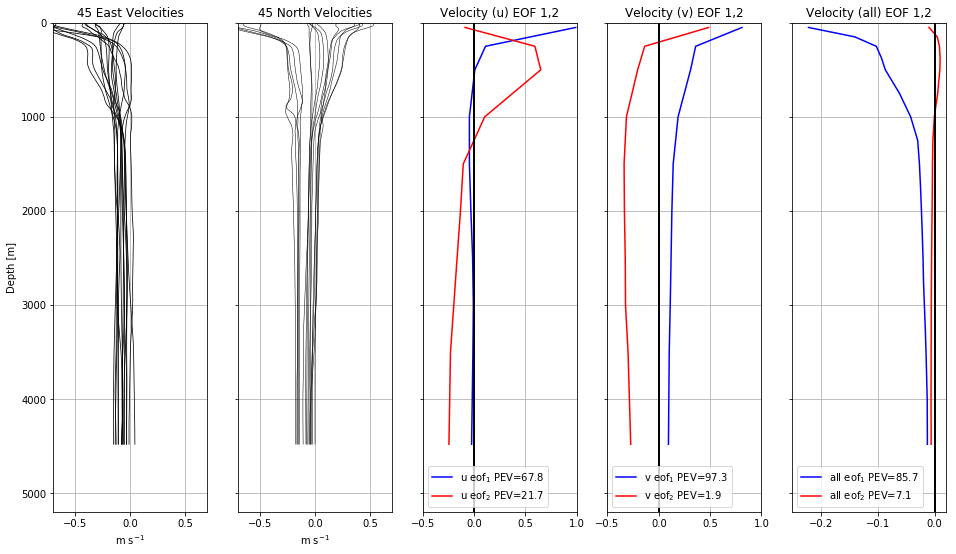

In [62]:
matplotlib.rcParams['figure.figsize'] = (16, 9)
f, (ax0, ax05, ax, ax2, ax3) = plt.subplots(1, 5, sharey=True)

for i in range(np.shape(u)[1]):
    ax0.plot(u[:, i], grid, color='k', linewidth=0.75)
ax0.set_title('45 East Velocities')
ax0.set_ylabel('Depth [m]')
ax0.set_xlabel(r'm s$^{-1}$')
ax0.grid()   
ax0.set_ylim([0, 5200])
ax0.set_xlim([-.7, .7])
for j in range(np.shape(v)[1]):
    ax05.plot(v[:, j], grid, color='k', linewidth=0.5)  
ax05.set_title('45 North Velocities')
ax05.set_xlabel(r'm s$^{-1}$')
ax05.grid()   
ax05.set_ylim([0, 5200])
ax05.set_xlim([-.7, .7])

eof1_norm = (1/np.nanmax(grid_check))*np.trapz(eof1[:, 0], x=grid_check)
eof1v_norm = (1/np.nanmax(grid_check))*np.trapz(eof1v[:, 0], x=grid_check)

ax.plot(UU[:, 0], grid_check, label=r'u eof$_1$ PEV=' + str(np.round(frac_eof[0]*100,1)), color='b')
ax.plot(UU[:, 1], grid_check, linestyle='-', label=r'u eof$_2$ PEV=' + str(np.round(frac_eof[1]*100,1)), color='r')
ax.plot([0, 0], [0, 5500], color='k', linewidth=2)

ax2.plot(UU2[:, 0], grid_check, label=r'v eof$_1$ PEV=' + str(np.round(frac_eof_v[0]*100,1)), color='b')
ax2.plot(UU2[:, 1], grid_check, linestyle='-', label=r'v eof$_2$ PEV=' + str(np.round(frac_eof_v[1]*100,1)), color='r')
ax2.plot([0, 0], [0, 5500], color='k', linewidth=2)

ax3.plot(eof1_all, grid[grid_sub_i_2], label=r'all eof$_1$ PEV=' + str(np.round(PEV_all[0]*100,1)), color='b')
ax3.plot(eof2_all, grid[grid_sub_i_2], label=r'all eof$_2$ PEV=' + str(np.round(PEV_all[1]*100,1)), color='r')
ax3.plot([0, 0], [0, 5500], color='k', linewidth=2)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=10)
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels, fontsize=10)
handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles, labels, fontsize=10)
ax.set_title('Velocity (u) EOF 1,2')
ax2.set_title('Velocity (v) EOF 1,2')
ax3.set_title('Velocity (all) EOF 1,2')
ax.invert_yaxis()
ax.set_xlim([-.5, 1])
ax2.set_xlim([-.5, 1])
ax3.set_xlim([-.25, .02])
ax.grid()
ax2.grid()
plot_pro(ax3)
f.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_19_09_04/sg045_uv_eof.jpg", dpi=300)

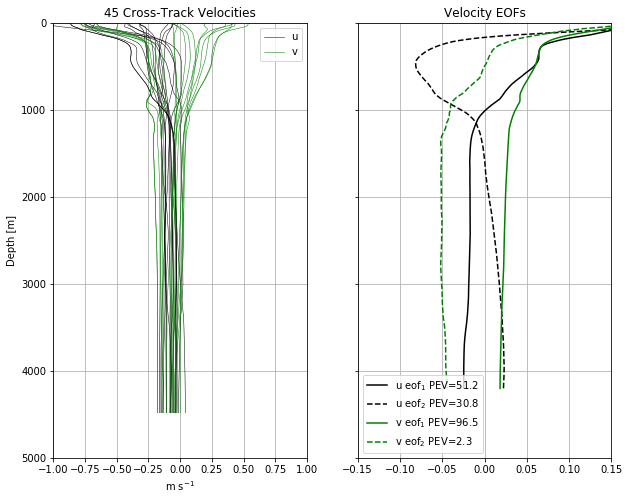

In [5]:
matplotlib.rcParams['figure.figsize'] = (10, 8)
f, (ax0, ax) = plt.subplots(1, 2, sharey=True)
for i in range(np.shape(u)[1]):
    ax0.plot(u[:, i], grid, color='k', linewidth=0.5)
for i in range(np.shape(v)[1]):
    ax0.plot(v[:, i], grid, color='g', linewidth=0.5)  
ax0.plot(u[:, i-2], grid, color='k', linewidth=0.5, label='u')
ax0.plot(v[:, i], grid, color='g', linewidth=0.5, label='v') 
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles, labels, fontsize=10)    
ax0.grid()   
ax0.set_ylim([0, 5000])
ax0.set_xlim([-1, 1])
ax0.set_title('45 Cross-Track Velocities')
ax0.set_ylabel('Depth [m]')
ax0.set_xlabel(r'm s$^{-1}$')
ax.plot(eof1, grid_check, label=r'u eof$_1$ PEV=' + str(np.round(PEV[0]*100,1)), color='k')
ax.plot(-1.0*eof2, grid_check, linestyle='--', label=r'u eof$_2$ PEV=' + str(np.round(PEV[1]*100,1)), color='k')
ax.plot(-1.0*eof1v, grid_check, label=r'v eof$_1$ PEV=' + str(np.round(PEVv[0]*100,1)), color='g')
ax.plot(eof2v, grid_check, linestyle='--', label=r'v eof$_2$ PEV=' + str(np.round(PEVv[1]*100,1)), color='g')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=10)
ax.set_title('Velocity EOFs')
ax.set_xlim([-.15, .15])
ax.invert_yaxis()
plot_pro(ax)
f.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_19_09_04/sg045_uv_eof.jpg", dpi=300)

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:253: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


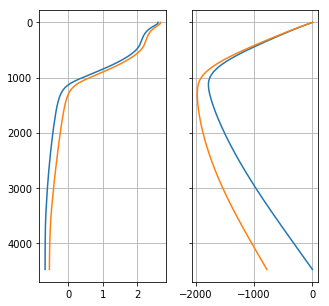

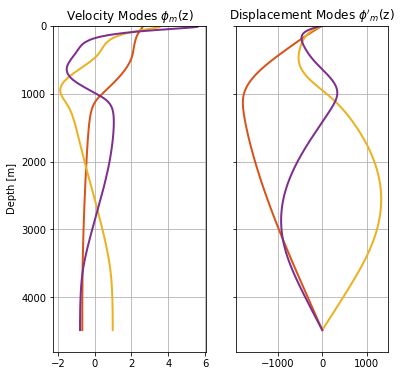

()

In [67]:
# --- VERTICAL MODES ---
# --- compute vertical mode shapes
# bckgrds_info = ['Win_1', 'Win_2', 'Win_3', 'Win_4', 'Sum_1', 'Sum_2', 'Sum_3', 'Sum_4',
#                 'Fall_1', 'Fall_2', 'Fall_3', 'Fall_4']
# N2 order = 
# G_0, Gz_0, c_0, epsilon_0 = vertical_modes(np.nanmean(N2[:, 0:4], axis=1), grid, omega, mmax)  # winter
# G_1, Gz_1, c_1, epsilon_1 = vertical_modes(np.nanmean(N2[:, 4:8], axis=1), grid, omega, mmax)  # summer
# G_2, Gz_2, c_2, epsilon_2 = vertical_modes(np.nanmean(N2[:, 8:], axis=1), grid, omega, mmax)  # fall
# Gs = [G_0, G_1, G_2]
# Gzs = [Gz_0, Gz_1, Gz_2]
# cs = [c_0, c_1, c_2]
# epsilons = [epsilon_0, epsilon_1, epsilon_2]
# test using average over entire year
# N2_tot = np.nanmean(N2, axis=1)
G_tot, Gz_tot, c_tot, epsilon_tot = vertical_modes(N2, grid, omega, mmax)  # N2

# --- compute alternate vertical modes (allowing for a sloping bottom)
bc_bot = 1  # 1 = flat, 2 = rough
slope = 3.0*10**(-4)  # 5.0*10**(-2)
grid2 = np.concatenate([np.arange(0, 150, 10), np.arange(150, 300, 10), np.arange(300, 4500, 10)])
n2_interp = np.interp(grid2, grid, N2)
n2_interp[0] = n2_interp[1] - 0.000001
F_int_g2, F_g2, c_ff, norm_constant, epsilon2 = vertical_modes_f(n2_interp, grid2, omega, mmax, bc_bot, ref_lat, slope)
F = np.nan * np.ones((np.size(grid), mmax + 1))
F_int = np.nan * np.ones((np.size(grid), mmax + 1))
for i in range(mmax + 1):
    F[:, i] = np.interp(grid, grid2, F_g2[:, i])
    F_int[:, i] = np.interp(grid, grid2, F_int_g2[:, i])

# --- test season differences in modes
cols = ['#2F4F4F', '#FF4500', '#DAA520', '#800080']
season_labs = ['Feb-Apr', 'May-Sept', 'Sept-Nov']

plt.rcParams['figure.figsize'] = 5, 5
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(Gz_tot[:, 1], grid)
ax1.plot(F[:, 1], grid)
ax2.plot(G_tot[:, 1], grid)
ax2.plot(F_int[:, 1], grid)
# ax1.set_ylim([900, 3500])
ax1.grid()
ax1.invert_yaxis()
plot_pro(ax2)

mode_colors = ['#0072BD', '#D85319', '#ECB120', '#7E2F8E']
plt.rcParams['figure.figsize'] = 6, 6
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(Gz_tot[:, 1], grid, color=mode_colors[1], linewidth=2)
ax1.plot(Gz_tot[:, 2], grid, color=mode_colors[2], linewidth=2)
ax1.plot(Gz_tot[:, 3], grid, color=mode_colors[3], linewidth=2)
# ax1.plot(F[:, 1], grid)
ax1.set_title(r'Velocity Modes $\phi_m$(z)')
ax1.set_ylabel('Depth [m]')
ax2.plot(G_tot[:, 1], grid, color=mode_colors[1], linewidth=2)
ax2.plot(G_tot[:, 2], grid, color=mode_colors[2], linewidth=2)
ax2.plot(G_tot[:, 3], grid, color=mode_colors[3], linewidth=2)
# ax2.plot(F_int[:, 1], grid)
ax2.set_title(r"Displacement Modes $\phi'_m$(z)")
ax1.set_ylim([0, 4800])
ax1.grid()
ax1.invert_yaxis()
plot_pro(ax2)

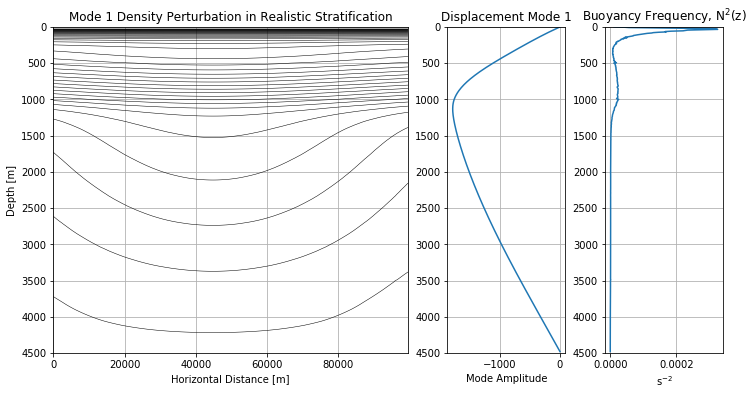

In [98]:
# schematic of mode 1 density perturbation 
xg = np.arange(0, 100000, 500)
gg = np.nanmean(gamma, axis=1)
ggg = np.tile(gg[:, None], (1, len(xg)))
# glev = np.concatenate((np.arange(23, 27.7, 0.2), np.arange(27.7, 27.9, 0.05), np.arange(27.86, 29, 0.01)))
glev = np.arange(24, 29, 0.1)

ggg2 = ggg.copy()
moder = np.tile(G_tot[:, 1][:, None], (1, len(xg))) * np.tile((np.sin(3.14 * xg / (np.nanmax(xg) - 10000))), (len(grid), 1)) * (1/10000)

from matplotlib import gridspec

fig = plt.figure(figsize=(12, 6)) 
gs = gridspec.GridSpec(1, 3, width_ratios=[3, 1, 1]) 
ax = plt.subplot(gs[0])
ax.contour(xg, grid, ggg + moder, colors='k', levels=glev, linewidths=0.5)
ax.set_ylim([0, 4500])
ax.invert_yaxis()
ax.grid()
ax.set_xlabel('Horizontal Distance [m]')
ax.set_ylabel('Depth [m]')
ax.set_title('Mode 1 Density Perturbation in Realistic Stratification')
ax2 = plt.subplot(gs[1])
ax2.plot(G_tot[:, 1], grid)
ax2.set_ylim([0, 4500])
ax2.invert_yaxis()
ax2.set_xlabel('Mode Amplitude')
ax2.set_title(r'Displacement Mode 1')
ax2.grid()
ax3 = plt.subplot(gs[2])
ax3.plot(N2, grid)
ax3.set_ylim([0, 4500])
ax3.set_xlabel(r's$^{-2}$')
ax3.set_title(r'Buoyancy Frequency, N$^2$(z)')
ax3.invert_yaxis()
plot_pro(ax3)
fig.savefig("/Users/jake/Documents/Post/bios_talk/mode1_schematic.jpg", dpi=300)

In [52]:
np.shape(np.tile(G_tot[:, 1][:, None], (1, len(xg))))
np.shape(np.tile((np.sin(3.14 * xg / np.nanmax(xg))), (len(grid), 1)))

(450, 100)

In [16]:
good_ke_prof_v

NameError: name 'good_ke_prof_v' is not defined

In [78]:
# ---- PROJECT MODES ONTO EACH PROFILE -------
# ---- Velocity and Eta (ENERGY)
sz = np.shape(mw_eta_3_good)
num_profs = sz[1]
AG_ind = np.zeros([nmodes, np.shape(eta_ind_3)[1]])
AG = np.zeros([nmodes, num_profs])
AGz_u = np.zeros([nmodes, np.shape(u)[1]])
AGz_v = np.zeros([nmodes, np.shape(v)[1]])

Eta_ind_m = np.nan * np.zeros([np.size(grid), np.shape(eta_ind_3)[1]])
Eta_m = np.nan * np.zeros([np.size(grid), num_profs])
V_m_u = np.nan * np.zeros([np.size(grid), np.shape(u)[1]])
V_m_v = np.nan * np.zeros([np.size(grid), np.shape(v)[1]])
Neta = np.nan * np.zeros([np.size(grid), num_profs])
NEta_m = np.nan * np.zeros([np.size(grid), num_profs])
PE_ind_per_mass = np.nan * np.zeros([nmodes, np.shape(eta_ind_3)[1]])
PE_per_mass = np.nan * np.zeros([nmodes, num_profs])
HKE_per_mass_u = np.nan * np.zeros([nmodes, np.shape(u)[1]])
HKE_per_mass_v = np.nan * np.zeros([nmodes, np.shape(v)[1]])
modest = np.arange(11, nmodes)
good_ke_prof_u = np.ones(np.shape(u)[1])
good_ke_prof_v = np.ones(np.shape(v)[1])
good_pe_prof = np.ones(num_profs)
HKE_noise_threshold = 1 * 1e-5  # 1e-5
PE_noise_threshold = 1e5

G = G_tot
Gz = Gz_tot
c = c_tot
this_N2 = N2 
# for i in range(num_profs):
# #     if len(np.intersect1d(d2_winter, i)) | ((mw_prof_good[i] > 60) & (mw_prof_good[i] < 71)):
# #         G = G_0
# #         Gz = Gz_0
# #         c = c_0
# #         this_N2 = np.nanmean(N2[:, 0:4], axis=1)
# #     elif len(np.intersect1d(d2_summer, i)):
# #         G = G_1
# #         Gz = Gz_1
# #         c = c_1
# #         this_N2 = np.nanmean(N2[:, 4:8], axis=1)
# #     else:
# #         G = G_2
# #         Gz = Gz_2
# #         c = c_2
# #         this_N2 = np.nanmean(N2[:, 8:], axis=1)
#     G = G_tot
#     Gz = Gz_tot
#     c = c_tot
#     this_N2 = np.nanmean(N2, axis=1)

for i in range(np.shape(u)[1]):  
    # fit to velocity profiles (U)
    this_V = u[:, i].copy() # SELECT U HERE 
    iv = np.where(~np.isnan(this_V))
    if iv[0].size > 1:
        AGz_u[:, i] = np.squeeze(np.linalg.lstsq(np.squeeze(Gz[iv, :]), np.transpose(np.atleast_2d(this_V[iv])))[0])
        # Gz(iv,:)\V_g(iv,ip)
        V_m_u[:, i] = np.squeeze(np.matrix(Gz) * np.transpose(np.matrix(AGz_u[:, i])))
        # Gz*AGz[:,i];
        # HKE_per_mass[:, i] = (1 / 2) * (AGz[:, i] * AGz[:, i])
        HKE_per_mass_u[:, i] = (AGz_u[:, i] * AGz_u[:, i])
        ival = np.where(HKE_per_mass_u[modest, i] >= HKE_noise_threshold)
        if np.size(ival) > 0:
            good_ke_prof_u[i] = 0  # flag profile as noisy
    else:
        good_ke_prof_u[i] = 0  # flag empty profile as noisy as well

for i in range(np.shape(v)[1]):         
    # fit to velocity profiles (V)
    this_V = v[:, i].copy() # SELECT V HERE 
    iv = np.where(~np.isnan(this_V))
    if iv[0].size > 1:
        AGz_v[:, i] = np.squeeze(np.linalg.lstsq(np.squeeze(Gz[iv, :]), np.transpose(np.atleast_2d(this_V[iv])))[0])
        # Gz(iv,:)\V_g(iv,ip)
        V_m_v[:, i] = np.squeeze(np.matrix(Gz) * np.transpose(np.matrix(AGz_v[:, i])))
        # Gz*AGz[:,i];
        # HKE_per_mass[:, i] = (1 / 2) * (AGz[:, i] * AGz[:, i])
        HKE_per_mass_v[:, i] = (AGz_v[:, i] * AGz_v[:, i])
        ival = np.where(HKE_per_mass_v[modest, i] >= HKE_noise_threshold)
        if np.size(ival) > 0:
            good_ke_prof_v[i] = 0  # flag profile as noisy
    else:
        good_ke_prof_v[i] = 0  # flag empty profile as noisy as well

# --- eta 
for i in range(np.shape(eta_ind_3[1, :])[0]): 
    # fit to individual eta profiles
    this_eta = eta_ind_3[:, i].copy()  # SELECT ETA HERE 
    # obtain matrix of NEta
    # Neta = this_N2 * this_eta
    iw = np.where((grid >= eta_fit_depth_min) & (grid <= eta_fit_depth_max))[0]
    if len(iw) > 1:
        eta_fs = this_eta.copy()  # ETA

        # -- taper fit as z approaches 0
        i_sh = np.where((grid < eta_fit_depth_min))
        eta_fs[i_sh[0]] = grid[i_sh] * this_eta[iw[0]] / grid[iw[0]]
        # -- taper fit as z approaches -H
        i_dp = np.where((grid > eta_fit_depth_max))[0]
        lgs = grid[iw[-1]]
        grid_ar = np.nan * np.ones(len(i_dp))
        for oo in range(len(grid[i_dp])):
            grid_ar[oo] = np.int(grid[i_dp[oo]])        
        eta_fs[i_dp] = (grid_ar - np.int(grid[-1])) * this_eta[iw[-1]] / (np.int(lgs) - grid[-1])

        # -- solve matrix problem
        AG_ind[1:, i] = np.linalg.lstsq(G[:, 1:], eta_fs[:, np.newaxis])[0][:, 0]
        # AG[1:, i] = np.linalg.lstsq(F_int[:, 1:], eta_fs[:, np.newaxis])[0][:, 0]

        Eta_ind_m[:, i] = np.squeeze(np.matrix(G) * np.transpose(np.matrix(AG_ind[:, i])))
        # Eta_m[:, i] = np.squeeze(np.matrix(F_int) * np.transpose(np.matrix(AG[:, i])))
        NEta = this_N2 * np.array(np.squeeze(np.matrix(G) * np.transpose(np.matrix(AG_ind[:, i]))))
        PE_ind_per_mass[:, i] = (1 / 2) * AG_ind[:, i] * AG_ind[:, i] * c * c

        np.where(PE_ind_per_mass[modest, i] >= PE_noise_threshold)
        iwal = np.where(PE_ind_per_mass[modest, i] >= PE_noise_threshold)
        # if np.size(iwal) > 0:
        #     good_pe_prof[i] = 0  # flag profile as noisy
        
for i in range(num_profs): 
    # fit to eta profiles
    this_eta = mw_eta_3_good[:, i].copy()  # SELECT ETA HERE 
    # obtain matrix of NEta
    Neta[:, i] = this_N2 * this_eta
    iw = np.where((grid >= eta_fit_depth_min) & (grid <= eta_fit_depth_max))[0]
    if len(iw) > 1:
        eta_fs = this_eta.copy()  # ETA

        # -- taper fit as z approaches 0
        i_sh = np.where((grid < eta_fit_depth_min))
        eta_fs[i_sh[0]] = grid[i_sh] * this_eta[iw[0]] / grid[iw[0]]
        # -- taper fit as z approaches -H
        i_dp = np.where((grid > eta_fit_depth_max))[0]
        lgs = grid[iw[-1]]
        grid_ar = np.nan * np.ones(len(i_dp))
        for oo in range(len(grid[i_dp])):
            grid_ar[oo] = np.int(grid[i_dp[oo]])        
        eta_fs[i_dp] = (grid_ar - np.int(grid[-1])) * this_eta[iw[-1]] / (np.int(lgs) - grid[-1])

        # -- solve matrix problem
        AG[1:, i] = np.linalg.lstsq(G[:, 1:], eta_fs[:, np.newaxis])[0][:, 0]
        # AG[1:, i] = np.linalg.lstsq(F_int[:, 1:], eta_fs[:, np.newaxis])[0][:, 0]

        Eta_m[:, i] = np.squeeze(np.matrix(G) * np.transpose(np.matrix(AG[:, i])))
        # Eta_m[:, i] = np.squeeze(np.matrix(F_int) * np.transpose(np.matrix(AG[:, i])))
        NEta_m[:, i] = this_N2 * np.array(np.squeeze(np.matrix(G) * np.transpose(np.matrix(AG[:, i]))))
        PE_per_mass[:, i] = (1 / 2) * AG[:, i] * AG[:, i] * c * c

        np.where(PE_per_mass[modest, i] >= PE_noise_threshold)
        iwal = np.where(PE_per_mass[modest, i] >= PE_noise_threshold)
        if np.size(iwal) > 0:
            good_pe_prof[i] = 0  # flag profile as noisy
# end loop over each v and eta for fitting

In [9]:
# --- check on mode amplitudes from averaging or individual profiles
# mw_time_ordered_i = np.argsort(mw_time_good)
# AG_ordered = AG[:, mw_time_ordered_i]
# AGz_ordered = AGz[:, mw_time_ordered_i]
# Time_ordered = mw_time_good[mw_time_ordered_i]
# HKE_per_mass = HKE_per_mass[:, mw_time_ordered_i]
# PE_per_mass = PE_per_mass[:, mw_time_ordered_i]
# Info3 = mw_prof_good[mw_time_ordered_i]
# V_ordered = mw_v_good[:, mw_time_ordered_i]
# Vm_ordered = V_m[:, mw_time_ordered_i]
# Eta_ordered = mw_eta_3_good[:, mw_time_ordered_i]  #SELECT ETA AGAIN HERE 
# Etam_ordered = Eta_m[:, mw_time_ordered_i]

In [70]:
# ----------------------------------------------------------------------------------------------------------------------
# --- ENERGY SPECTRA ---
# ----------------------------------------------------------------------------------------------------------------------
# -- initial params
f_ref = np.pi * np.sin(np.deg2rad(ref_lat)) / (12 * 1800)
dk = f_ref / c_tot[1]
sc_x = 1000 * f_ref / c_tot[1:]

# --- PE, KE selection (exclude eddy)
HKE_per_mass_u_0 = HKE_per_mass_u.copy()
HKE_per_mass_v_0 = HKE_per_mass_v.copy()
PE_per_mass_0 = PE_per_mass.copy()

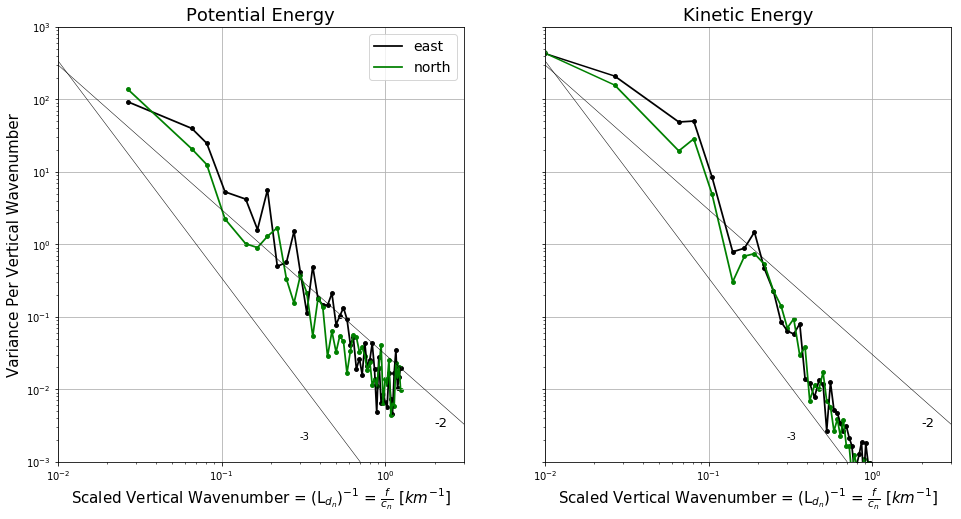

()

In [71]:
# --- PLOT ENERGY 

matplotlib.rcParams['figure.figsize'] = (16,8)
f_s_en, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
lw = [1.75, 1.75, 1.75, .8]
scz = [15, 15, 15, 6]
sort_by_uv = [[0,1,2,6,7,8], [3,4,5,9,10,11]] #avg across two u transects and two v transects (will need to update)
labs = ['east', 'north']
cols = ['k', 'g']
inn = [np.where((box_side_info == 1) | (box_side_info == 3))[0], np.where((box_side_info == 0) | (box_side_info == 2))[0]]
ax1.plot(sc_x, np.nanmean(PE_per_mass_0[1:, inn[0]], axis=1) / dk, color=cols[0], label=labs[0], linewidth=lw[0])
ax1.scatter(sc_x, np.nanmean(PE_per_mass_0[1:, inn[0]], axis=1) / dk, color=cols[0], s=scz[0])
ax1.plot(sc_x, np.nanmean(PE_per_mass_0[1:, inn[1]], axis=1) / dk, color=cols[1], label=labs[1], linewidth=lw[1])
ax1.scatter(sc_x, np.nanmean(PE_per_mass_0[1:, inn[1]], axis=1) / dk, color=cols[1], s=scz[1])
    
ax2.plot(sc_x, np.nanmean(HKE_per_mass_u_0[1:, :], axis=1) / dk, color=cols[0], label=labs[0], linewidth=lw[0])
ax2.scatter(sc_x, np.nanmean(HKE_per_mass_u_0[1:, :], axis=1) / dk, color=cols[0], s=scz[0])
ax2.plot([10**-2, 1000 * f_ref / c[1]], np.nanmean(HKE_per_mass_u_0, axis=1)[0:2] / dk, color=cols[0], linewidth=1.5)
ax2.scatter(10**-2, np.nanmean(HKE_per_mass_u_0, axis=1)[0] / dk, color=cols[0], s=scz[0]*1.5, facecolors='none')

ax2.plot(sc_x, np.nanmean(HKE_per_mass_v_0[1:, :], axis=1) / dk, color=cols[1], label=labs[1], linewidth=lw[1])
ax2.scatter(sc_x, np.nanmean(HKE_per_mass_v_0[1:, :], axis=1) / dk, color=cols[1], s=scz[1])
ax2.plot([10**-2, 1000 * f_ref / c[1]], np.nanmean(HKE_per_mass_v_0, axis=1)[0:2] / dk, color=cols[1], linewidth=1.5)
ax2.scatter(10**-2, np.nanmean(HKE_per_mass_v_0, axis=1)[0] / dk, color=cols[1], s=scz[1]*1.5, facecolors='none')


# modeno = '1', '2', '3', '4', '5', '6', '7', '8'   
# for i in range(len(modeno)):
#     ax1.text(sc_x[i], (np.nanmean(PE_per_mass_0[i + 1, bckgrds[0]]) / dk) + 
#              (np.nanmean(PE_per_mass_0[i + 1, bckgrds[0]]) / dk)/7, modeno[i], color=cols[0])    
# -- GM
# ax1.plot(1000 * sta_bats_f / sta_bats_c[1:], 0.25 * PE_GM_bats / sta_bats_dk, color='k', linewidth=0.75, linestyle='--')
# ax1.text(1000 * sta_bats_f / sta_bats_c[1] - .01, 0.5 * PE_GM_bats[1] / sta_bats_dk, r'$1/4 PE_{GM}$', fontsize=10)
# ax2.plot(1000 * sta_bats_f / sta_bats_c[1:], 0.25 * GMKE_bats / sta_bats_dk, color='k', linewidth=0.75, linestyle='--')
# ax2.text(1000 * sta_bats_f / sta_bats_c[1] - .01, 0.5 * GMKE_bats[1] / sta_bats_dk, r'$1/4 KE_{GM}$', fontsize=10)    
ax1.plot([7 * 10**-3, 7 * 10**-1], [10**3, 10**-3], color='k', linewidth=0.5)
ax1.text(3*10**-1, 2*10**-3, '-3', fontsize=10)
ax1.plot([10**-2, 10**1], [3*10**2, 3*10**-4], color='k', linewidth=0.5)
ax1.text(2*10**0, 3*10**-3, '-2', fontsize=13)
ax2.plot([7 * 10**-3, 7 * 10**-1], [10**3, 10**-3], color='k', linewidth=0.5)
ax2.text(3*10**-1, 2*10**-3, '-3', fontsize=10)
ax2.plot([10**-2, 10**1], [3*10**2, 3*10**-4], color='k', linewidth=0.5)
ax2.text(2*10**0, 3*10**-3, '-2', fontsize=13)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, fontsize=14)
ax1.set_xlabel(r'Scaled Vertical Wavenumber = (L$_{d_{n}}$)$^{-1}$ = $\frac{f}{c_n}$ [$km^{-1}$]', fontsize=15)
ax1.set_ylabel('Variance Per Vertical Wavenumber', fontsize=15)
ax1.set_title('Potential Energy', fontsize=18)
ax1.set_xlim([10 ** -2, 3 * 10 ** 0])
ax1.set_ylim([10 ** (-3), 1 * 10 ** 3])
ax1.set_yscale('log')
ax1.set_xscale('log')
ax2.set_xlabel(r'Scaled Vertical Wavenumber = (L$_{d_{n}}$)$^{-1}$ = $\frac{f}{c_n}$ [$km^{-1}$]', fontsize=15)
ax2.set_title('Kinetic Energy', fontsize=18)
ax2.set_xlim([10 ** -2, 3 * 10 ** 0])
ax2.set_xscale('log')
ax1.grid()
plot_pro(ax2)
# f_s_en.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_19_09_04/sg045_pe_ke.jpg", dpi=300)

In [83]:
u_no

array([ 50.5,  51. ,  51.5,  58.5,  59. ,  59.5,  63.5,  64. ,  64.5,
        65. ,  65.5,  66. ,  66.5,  67. ,  67.5])

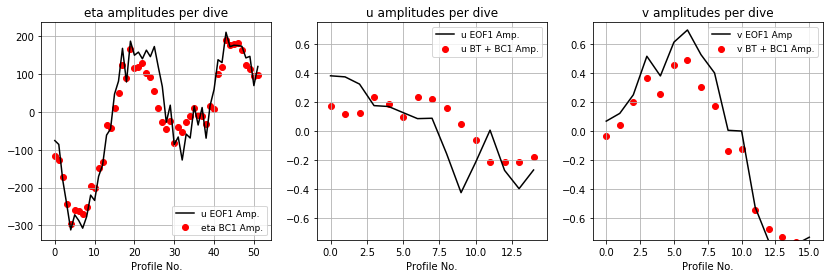

()

In [95]:
Amp1_u = VV[0, :]*SS[0]
Amp1_v = VV2[0, :]*SS2[0]
Amp1_eta = VVe[0, :]*SSe[0]

matplotlib.rcParams['figure.figsize'] = (14, 4)
f, (ax0, ax1, ax2) = plt.subplots(1, 3)
ax0.plot(np.arange(0, len(Amp1_eta)), Amp1_eta, color='k', label='u EOF1 Amp.')
ax0.scatter(np.arange(0, len(AG_ind[1, :])), 5000*AG_ind[1, :], color='r', label='eta BC1 Amp.')
ax0.grid()
ax1.plot(np.arange(0, nq), Amp1_u, color='k', label='u EOF1 Amp.')
ax1.scatter(np.arange(0, nq), -2.5*(AGz_u[0, :]) + 2.5*(AGz_u[1, :]) + 2.5*(AGz_u[2, :]), color='r', label='u BT + BC1 Amp.')
ax2.plot(np.arange(0, nq_v), Amp1_v, color='k', label='v EOF1 Amp')
ax2.scatter(np.arange(0, nq_v), 3*(AGz_v[0, :] + AGz_v[1, :]), color='r', label='v BT + BC1 Amp.')
ax1.grid()
ax1.set_ylim([-.75, .75])
ax2.set_ylim([-.75, .75])
ax0.set_title('eta amplitudes per dive')
ax1.set_title('u amplitudes per dive')
ax2.set_title('v amplitudes per dive')
ax0.set_xlabel('Profile No.')
ax1.set_xlabel('Profile No.')
ax2.set_xlabel('Profile No.')
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles, labels, fontsize=9)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, fontsize=9)
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels, fontsize=9)
plot_pro(ax2)
# f.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_19_09_04/sg045_eof_mode_amps.jpg", dpi=300)